# Notebook generating picca calls for computing $P_{F,1d} (k)$ and showing QA plots

Please follow the **[this notebook](QA_plots.ipynb)** notebook for general remarks on how to set up the environment at NERSC, **maybe use [the developer edition of the notebook server](jupyter-dev.nersc.gov)** as this runs on a high-memory cori node (and should even allow generating batch jobs on arbitrary nodes from within the notebook) vs. some special thing in the standard version.

## imports

In [33]:
from pathlib import Path
import subprocess
import glob
import sys
import numpy as np
import scipy as sp
import scipy.stats as spstats
import matplotlib.pyplot as plt
import fitsio
from astropy.io import fits   #this is currently only used for slicing the catalogue, maybe get rid of the dependency by restructuring
import picca
from picca.Pk1D import Pk1D
from matplotlib import rc,rcParams

## define the root directory for outputs

In [35]:
basedir=Path.home()
basedir

PosixPath('/global/homes/m/mwalther')

## set plotting style options

In [8]:
rcParams['text.usetex'] = False                      #setting this to true causes problems on NERSC because some files can't be created without sudo-rights
rcParams['text.latex.unicode'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

%matplotlib inline

## set flags and variables

Stuff needed if only a subset of the full catalogue should be used (to speed things up for debugging)

In [9]:
usesubset=False     #should a subset of the full catalogue be used (note that everything takes hours if this is set to False)
rarange=2          #range in ra for subset
decrange=2         #range in dec for subset

Definition of variables needed to define the mocks

In [10]:
#mock_base = '/project/projectdirs/desi/mocks/lya_forest/saclay/v3.1/'                                               #for some older Saclay mocks without redshift evolution
#mock_base = '/project/projectdirs/desi/mocks/lya_forest/london/v4.0.9/'                                             #for the london mocks
mock_base = '/global/projecta/projectdirs/desi/mocks/lya_forest/develop/debug/1024-1024-1536/mock_0/output/'         #for the very latest Saclay mocks
quick_ver = 'quick-0.1'

## File/Directory names

Picca installation path and a string to activate the environment for subprocesses

In [11]:
piccadir=Path('/'+'/'.join(Path(picca.__file__).parts[1:-3])+'/')
activate_string='bash -c "source activate picca_plots;'

Catalogue file for the full catalogue

In [12]:
if 'saclay' in mock_base or 'debug' in mock_base:
    zcat=Path('{}/{}/zcat.fits'.format(mock_base,quick_ver))
    stringid='_'.join(zcat.parts[-4:])[:-5]
    catfile=(basedir/'zcat_drq_saclay'/'{}_desi_drq.fits'.format('_'.join(zcat.parts[-4:])[:-5]))
    if not catfile.parent.exists():
        Path.mkdir(catfile.parent,parents=True)
    picca.utils.desi_from_ztarget_to_drq(zcat.as_posix(),catfile.as_posix())
    outcatfile=basedir/'catalogues_small/'/(stringid+'_reduced_rarange{}_decrange{}.fits'.format(rarange,decrange))
else:
    catfile=Path('{}/{}/zcat_desi_drq.fits'.format(mock_base,quick_ver))
    stringid='_'.join(catfile.parts[-4:])[:-5]
    outcatfile=basedir/'catalogues_small/'/('_'.join(catfile.parts[-4:])[:-5]+'_reduced_rarange{}_decrange{}.fits'.format(rarange,decrange))


 start               : nb object in cat = 153682
 and zwarn==0        : nb object in cat = 153682
 and spectype==QSO    : nb object in cat = 153682


Mock files

In [13]:
indir=Path('{}/{}/spectra-16/'.format(mock_base,quick_ver))

Output directories/files for the subset of mocks, the delta fields and Pk

In [14]:
outdir_delta=basedir/'res_ascii_{}{}/'.format(stringid,'_subset_rarange{}_decrange{}'.format(rarange,decrange) if usesubset else '')
outdir_Pk=basedir/'Pk_fits{}/'.format(stringid,'_subset_rarange{}_decrange{}'.format(rarange,decrange) if usesubset else '')

Check that output dirs exist (else create)

In [15]:
if usesubset and not outcatfile.parent.exists():
    Path.mkdir(outcatfile.parent,parents=True)
if not outdir_Pk.exists():
    Path.mkdir(outdir_Pk,parents=True)
if not outdir_delta.exists():
    Path.mkdir(outdir_delta,parents=True)

## Create a subset of the mock catalogue

open the mock catalogue

In [16]:
cat=fits.open(catfile)
dec=cat[1].data['DEC']
ra=cat[1].data['RA']

define some range to use

In [17]:
select=(np.abs(dec-40)<decrange)&(np.abs(ra-180)<rarange)

slice the catalogue

In [18]:
if usesubset:
    cat[1].data=cat[1].data[select]

write to a file

In [19]:
if usesubset:
    try:
        cat.writeto(outcatfile)
    except OSError:
        print('File exists, using existing file')

## use picca to compute the delta field

generate the call defined by the directories above

In [20]:
callstring_delta=('{call} --in-dir {indir} --drq {drq} --out-dir {outdir} --mode desi --delta-format Pk1D_ascii --rebin 1 --lambda-min 3650. --lambda-max 7200.0 '
                  '--lambda-rest-min 1050.0 --lambda-rest-max 1180 --nproc 4 --order 0 --use-constant-weight --iter-out-prefix {iter_out_prefix} --log {log}'.format(
                     call=piccadir/'bin/do_deltas.py', indir=indir.as_posix()+'/',drq=(outcatfile if usesubset else catfile).as_posix(),outdir=outdir_delta.as_posix()+'/',
                     iter_out_prefix=outdir_delta.as_posix()+'/iter',log=outdir_delta.as_posix()+'/delta.log'))

In [16]:
#this is for testing with non-ascii intermediate formats
#callstring_delta=('{call} --in-dir {indir} --drq {drq} --out-dir {outdir} --mode desi --delta-format Pk1D --rebin 1 --lambda-min 3650. --lambda-max 7200.0 '
#                  '--lambda-rest-min 1050.0 --lambda-rest-max 1180 --nproc 4 --order 0 --use-constant-weight'.format(
#                     call=piccadir/'bin/do_deltas.py', indir=indir.as_posix()+'/',drq=(outcatfile if usesubset else catfile).as_posix(),outdir=outdir_delta.as_posix()+'/'))

In [21]:
callstring_delta

'/global/u1/m/mwalther/igmhub/picca/bin/do_deltas.py --in-dir /global/projecta/projectdirs/desi/mocks/lya_forest/develop/debug/1024-1024-1536/mock_0/output/quick-0.1/spectra-16/ --drq /global/homes/m/mwalther/zcat_drq_saclay/mock_0_output_quick-0.1_zcat_desi_drq.fits --out-dir /global/homes/m/mwalther/res_ascii_mock_0_output_quick-0.1_zcat/ --mode desi --delta-format Pk1D_ascii --rebin 1 --lambda-min 3650. --lambda-max 7200.0 --lambda-rest-min 1050.0 --lambda-rest-max 1180 --nproc 4 --order 0 --use-constant-weight --iter-out-prefix /global/homes/m/mwalther/res_ascii_mock_0_output_quick-0.1_zcat/iter --log /global/homes/m/mwalther/res_ascii_mock_0_output_quick-0.1_zcat/delta.log'

---

define an additional string to enable launching subprocesses in the right conda environment

In [22]:
call_delta_full='{} {}"'.format(activate_string,callstring_delta)

use subprocess to actually run the call **do not execute this line unless you're willing to wait for minutes (for subsets) to hours (for full sample)**

TODO: Instead of using subprocess directly maybe use %%sbatch to create a batch script submitted to the queue (this needs some package installations however)

In [19]:
if len({p for p in outdir_delta.rglob('*') if p.is_file()})==0:
    pr_delta=subprocess.run(args=call_delta_full,shell=True,check=True,capture_output=True)
    #print(pr_delta.stdout)
else:
    print('Directory must be empty!')

Directory must be empty!


## Compute the power with picca

In [23]:
callstring_Pk=('{call} --in-dir {indir} --in-format ascii --out-dir {outdir} --lambda-obs-min 3750. --noise-estimate pipeline --no-apply-filling'.format(
                     call=piccadir/'bin/do_Pk1D.py', indir=outdir_delta.as_posix(),outdir=outdir_Pk.as_posix()))

In [24]:
#this is for testing of non-ascii intermediate formats
#callstring_Pk=('{call} --in-dir {indir} --in-format fits --out-dir {outdir} --lambda-obs-min 3750. --noise-estimate pipeline --no-apply-filling'.format(
#                     call=piccadir/'bin/do_Pk1D.py', indir=outdir_delta.as_posix(),outdir=outdir_Pk.as_posix()))

In [25]:
callstring_Pk

'/global/u1/m/mwalther/igmhub/picca/bin/do_Pk1D.py --in-dir /global/homes/m/mwalther/res_ascii_mock_0_output_quick-0.1_zcat --in-format ascii --out-dir /global/homes/m/mwalther/Pk_fitsmock_0_output_quick-0.1_zcat --lambda-obs-min 3750. --noise-estimate pipeline --no-apply-filling'

---

define an additional string to enable launching subprocesses in the right conda environment

In [26]:
call_Pk_full='{} {}"'.format(activate_string,callstring_Pk)

use subprocess to actually run the call **do not execute this line unless you're willing to wait for minutes (for subsets) to hours (for full sample)**

In [27]:
if len({p for p in outdir_delta.rglob('*') if p.is_file()})==0:
    pr_Pk=subprocess.run(args=call_Pk_full,shell=True,check=True,capture_output=True)
    #print(pr_Pk.stdout)
else:
    print("Directory must be empty!")

Directory must be empty!


## Create the plot (based on Christophe's routine)

arguments for the plot

In [28]:
args={}
args['reso_max']=85.
args['SNR_min']=2.
args['z_min']=2.1
args['out_fig']=outdir_Pk/'plot_pk1d_notebook'

settings for the plot

In [29]:
figure_file = args['out_fig']

zbins = [ 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6]
colors = ['m', 'r', 'b', 'k', 'chartreuse', 'gold', 'aqua', 'slateblue', 'orange', 'mediumblue', 'darkgrey', 'olive', 'firebrick']
s = 6
fontt = 16
fontlab = 10
fontl =12

set up the desired binning (as in the BOSS paper)

In [30]:
nb_z_bin=7 #13 #BOSS value #shouldn't this just be len(zbins)
nb_k_bin=60 #BOSS used 35
k_inf=0.000813
k_bin_dist=0.000542
k_sup=k_inf + nb_k_bin*k_bin_dist

In [31]:
def plot_data(data_dir):
    #generate arrays
    sumPk = sp.zeros([nb_z_bin,nb_k_bin],dtype=sp.float64)
    sumPk2 = sp.zeros([nb_z_bin,nb_k_bin],dtype=sp.float64)
    sum = sp.zeros([nb_z_bin,nb_k_bin],dtype=sp.float64)
    ek = sp.zeros([nb_k_bin],dtype=sp.float64)
    k=k_inf + (np.arange(nb_k_bin)+0.5)*k_bin_dist

    #search for all P(k) files

    fi = glob.glob("{}/*.fits.gz".format(data_dir))

    #initialize the data arrays

    data = {}
    ndata = 0

    #loop over files

    for i,f in enumerate(fi):
        if i%1==0:
            sys.stderr.write("\rread {} of {} {}".format(i,len(fi),ndata))

        # read fits files
        hdus = fitsio.FITS(f)
        pk1ds = [Pk1D.from_fitsio(h) for h in hdus[1:]]
        ndata+=len(pk1ds)
        #print ("\n ndata =  ",ndata)

        # loop over pk1ds
        for pk in pk1ds:

            # Selection over the SNR and the resolution
            if (pk.mean_snr<=args['SNR_min'] or pk.mean_reso>=args['reso_max']) : continue

            if(pk.mean_z<=args['z_min']) : continue

            iz = int((pk.mean_z-args['z_min'])/0.2)
            if(iz>=nb_z_bin or iz<0) : continue
            for i in range (len(pk.k)) :
                ik = int((pk.k[i]-k_inf)/(k_sup-k_inf)*nb_k_bin);
                if(ik>= nb_k_bin or ik<0) : continue
                Delta2 = pk.Pk[i]*pk.k[i]/sp.pi
                sumPk[iz,ik] += Delta2
                sumPk2[iz,ik] += Delta2**2
                sum[iz,ik] += 1.0

    #Compute means and errors

    meanPk = sp.where(sum!=0,sumPk/sum,0.0)
    errorPk = sp.where(sum!=0,sp.sqrt(((sumPk2/sum)-meanPk**2)/sum),0.0)

    #Do the actual plotting
    
    for kmax in [0.02,0.033]:

        fig = plt.figure(figsize = (16, 8))
        ax = fig.add_subplot(111)
        plt.yscale('log')

        for iz in range(nb_z_bin) :
            z = 2.2 + iz*0.2
            #ax.errorbar(k,meanPk[iz,:], yerr =errorPk[iz,:], fmt = 'o', color = colors[iz], markersize = s, label =r'\bf {:1.1f} $\displaystyle <$ z $\displaystyle <$ {:1.1f}'.format(z-0.1,z+0.1))
            ax.errorbar(k,meanPk[iz,:], yerr =errorPk[iz,:], fmt = 'o', color = colors[iz], markersize = s, label =r' z = {:1.1f}'.format(z))

        #ax.set_xlabel(r'\bf $\displaystyle k [km.s^{-1}]$', fontsize = fontt)
        ax.set_xlabel(r' k [km/s]', fontsize = fontt)
        #ax.set_ylabel(r'\bf $\displaystyle \Delta^2_{\mathrm{1d}}(k) $', fontsize=fontt, labelpad=-1)
        ax.set_ylabel(r'$\Delta^2_{1d}$ ', fontsize=fontt, labelpad=-1)
        ax.xaxis.set_ticks_position('both')
        ax.xaxis.set_tick_params(direction='in')
        ax.yaxis.set_ticks_position('both')
        ax.yaxis.set_tick_params(direction='in')
        ax.xaxis.set_tick_params(labelsize=fontlab)
        ax.yaxis.set_tick_params(labelsize=fontlab)
        ax.set_xlim(0,kmax)
        ax.set_ylim(5e-3,0.3)
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1.03, 0.98), borderaxespad=0.,fontsize = fontl)
        fig.subplots_adjust(top=0.98,bottom=0.114,left=0.078,right=0.758,hspace=0.2,wspace=0.2)

        fig.savefig(figure_file.with_name(figure_file.name+'kmax_{}.pdf'.format(kmax)), transparent=False)

### Plot the new Saclay mocks

read 23 of 24 75470

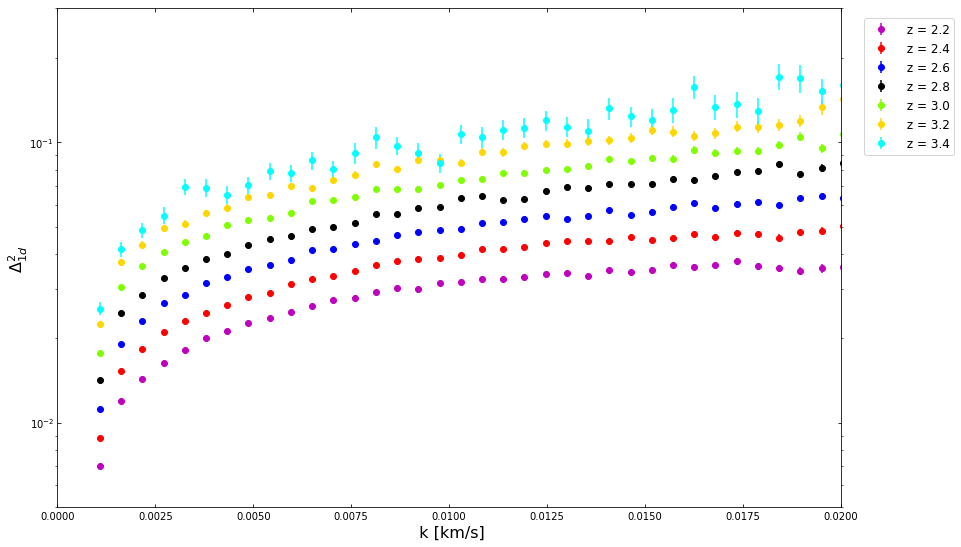

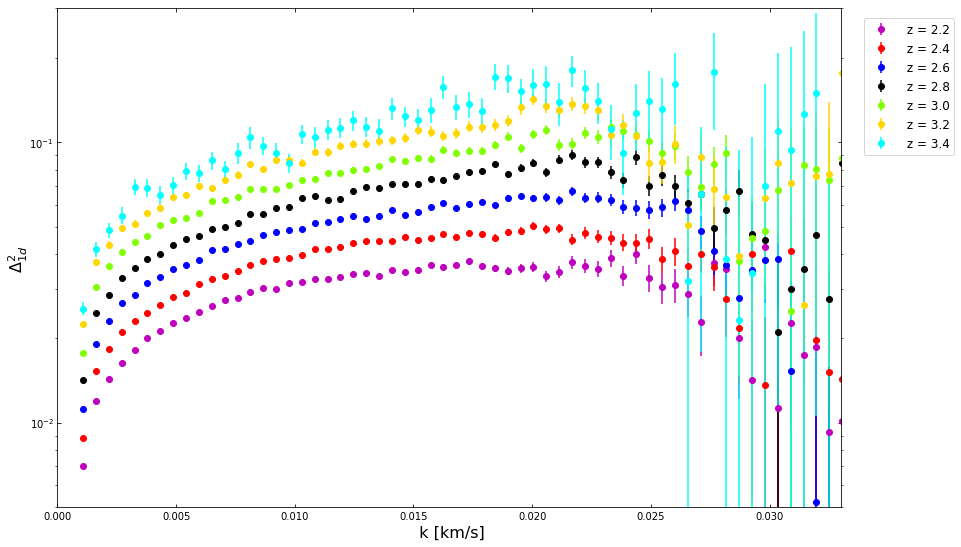

In [66]:
plot_data(outdir_Pk)

### Plot a small subset of the London Mocks

read 9 of 10 11952

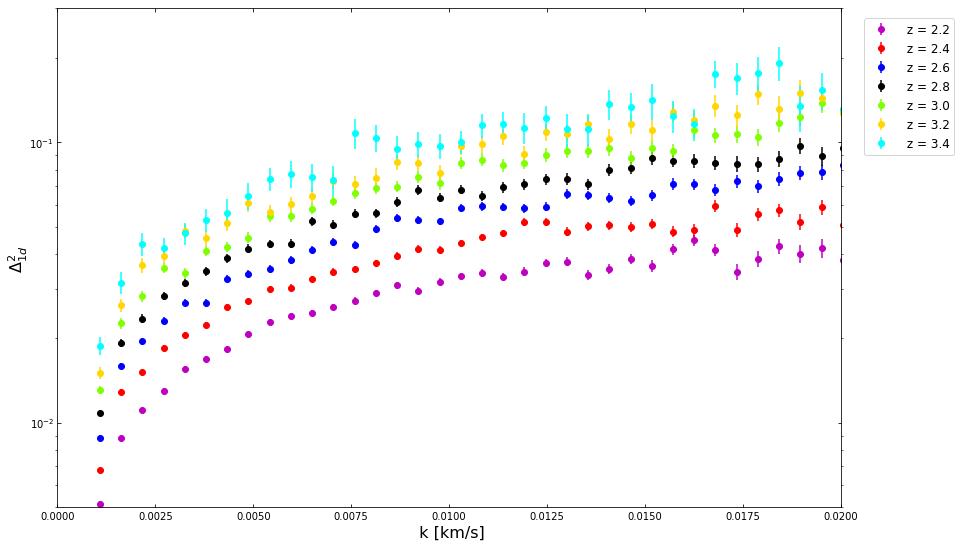

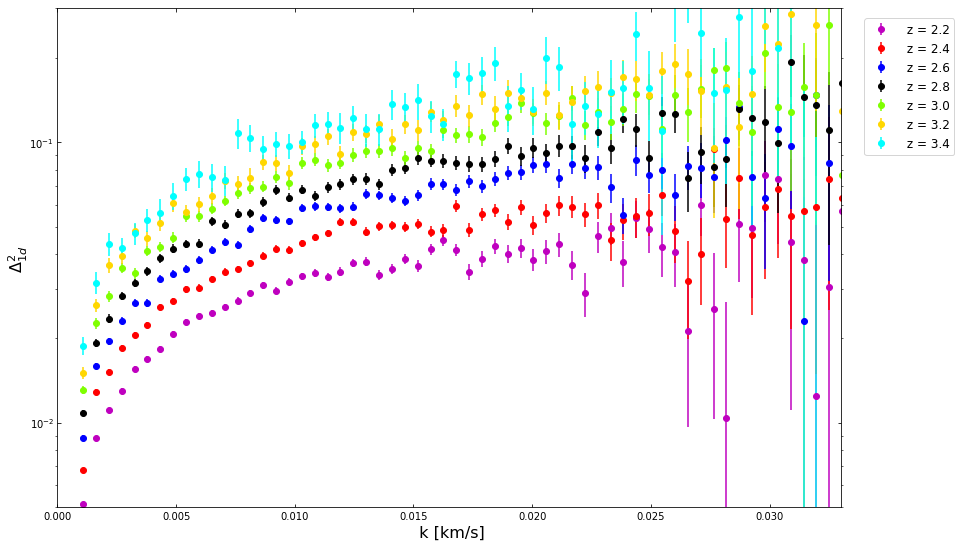

In [32]:
plot_data(basedir/'Pk_fits_red')

### Plot most of the London Mocks (takes a while)

read 295 of 296 819989

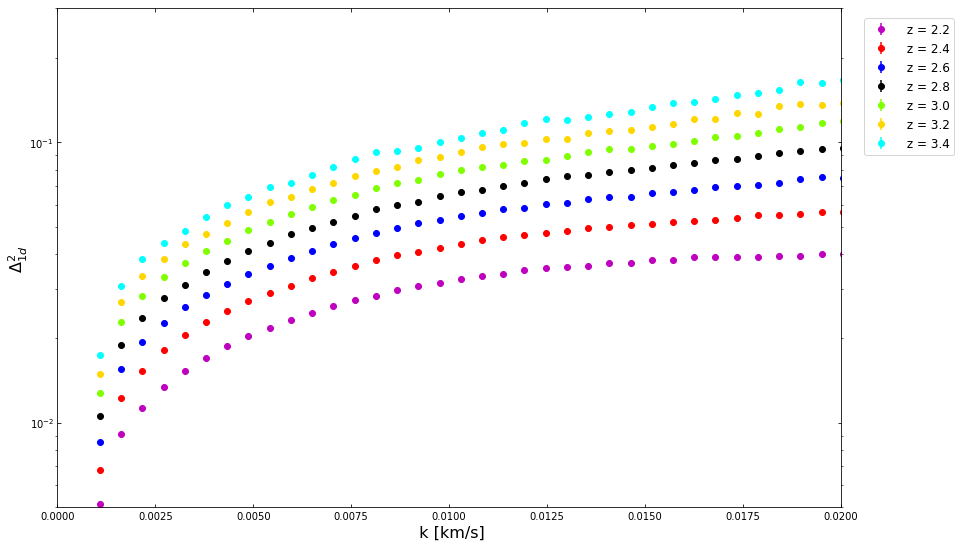

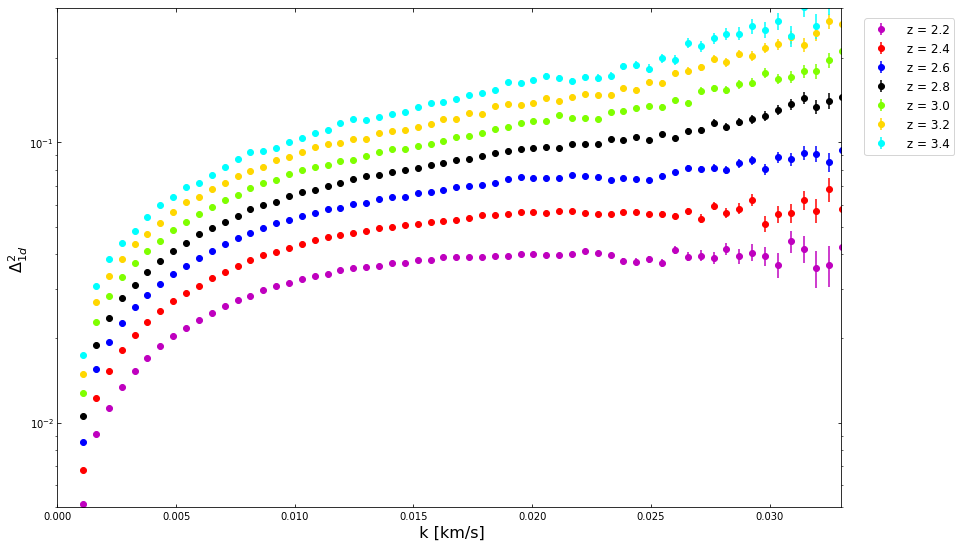

In [68]:
plot_data(basedir/'Pk_fits')